In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.patheffects as pe
import os
import matplotlib.pyplot as plt
import seaborn as sns
# Seaborn aesthetics
sns.set_context("notebook")
sns.set_theme(style="whitegrid", font_scale=1.4,
              rc={'grid.color': '#ededed'})

from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
import statsmodels.api as sm
import scipy
from scipy.stats import gaussian_kde
from matplotlib.colors import to_rgba

In [2]:
###################
###################

In [3]:

###
# fpath = "/data/shared/src/arojas/NEON/veg-db/data/output/NEON_VST_TREES.csv"
fpath = "/data/shared/src/arojas/NEON/veg-db/data/output/NEON_VST_TREES_2020to2023.csv"
neon_vst = pd.read_csv(fpath)


In [4]:
neon_vst.shape

(117910, 45)

In [5]:
## Clean data
# Use only live trees
neon_vst_filt = neon_vst[neon_vst['plantStatus'].str.contains("Live", na=False)].reset_index(drop=True)
neon_vst_filt = neon_vst_filt[~neon_vst_filt['plantStatus'].str.contains("damage|broken", na=False)].reset_index(drop=True)
# Get average crown diameter
neon_vst_filt["avgCrownDiameter"] = (neon_vst_filt["maxCrownDiameter"] + neon_vst_filt["ninetyCrownDiameter"])/2
neon_vst_filt['crownRadius'] = neon_vst_filt['avgCrownDiameter']/2
# Get vertical crown diameter
neon_vst_filt["verticalDiameter"] = neon_vst_filt["height"] - neon_vst_filt["baseCrownHeight"]
neon_vst_filt['verticalCrownRadius'] = neon_vst_filt['verticalDiameter']/2
# calculate crown volume 
hrad = neon_vst_filt["avgCrownDiameter"]/2
vrad = neon_vst_filt["verticalDiameter"]/2
# appidv_all['crown_vol'] =(4/3) * np.pi * (hrad**2) * (vrad)
neon_vst_filt['crown_vol'] =(4/3) * np.pi * (hrad**2) * ((1/4)*neon_vst_filt["height"])

# Remove data with errors (large DBH, height, etc.)
outlier_trees = ['NEON.PLA.D17.SOAP.05687']
neon_vst_filt = neon_vst_filt[~neon_vst_filt['individualID'].isin(outlier_trees)].copy().reset_index(drop=True)

# # filter for only trees
# growthForm_list = ['single bole tree', 'multi-bole tree','small tree'] # 'small tree'
# # growthForm_list = ['small tree']
# neon_vst_filt = neon_vst_filt[neon_vst_filt['growthForm'].isin(growthForm_list)].copy()


In [6]:
neon_vst_filt.shape

(85817, 50)

In [7]:
############
## Allometry
############

In [8]:
## Linear regression function
from scipy import stats
import numpy as np

def LinearRegression(x,y):
    """
    returns: regression model
    """
    filterbool = ~(np.isnan(x) | np.isnan(y))
    x = x[filterbool]
    y = y[filterbool]
    # Simple OLS linear regression using scipy stats, which is what statsmodel depends on
    try:
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    except:
        print(f"Not enough data. Length: ", len(x))
        return np.nan, np.nan, np.nan, np.nan, np.nan
    return slope, intercept, r_value, p_value, std_err

In [9]:
mpl_colors = ['#1f77b4', '#ff7f0e','#9467bd', '#2ca02c']

In [10]:
import matplotlib.ticker as plticker
from matplotlib.colors import to_rgba
import matplotlib.patheffects as pe

selected_domains = ['D01', 'D02', 'D03', 'D04',
                    'D05', 'D06', 'D07', 'D08',
                    'D10', 'D11', 'D12', 'D13',
                    'D15', 'D16', 'D17', 'D19', 'D20']


## Plotting and output params
outdir = "../../figs/veg-struct/allom/2020to2023"
if not os.path.isdir(outdir):
    os.mkdir(outdir)
# Choose structural variable to plot

xvars_list = ["stemDiameter", "stemDiameter","height","height"]
yvars_list = ["height", "crownRadius","crownRadius","crown_vol"]

xlabs_list = ["ln(D)", "ln(D)","ln(H)", "ln(H)"]
ylabs_list = ["ln(H)", r"ln($R_{hc}$)",r"ln($R_{hc}$)", r"ln($V_{c}$)"]

for var_idx, yvar in enumerate(yvars_list):
    
    # get xvar and labels
    xvar = xvars_list[var_idx]
    xlabel = xlabs_list[var_idx]
    ylabel = ylabs_list[var_idx]
    
    
    # Create figure
    fig, axs = plt.subplots(6,3, figsize=(8,12), sharex=True, sharey=True)
    ax = axs.flatten()

    # Loop through domains and plot allom
    plot_idx = 0
    for domain, group in neon_vst_filt.groupby("domainID"):
#         print(domain)

        if domain not in selected_domains:
            # use selected domains only!
            continue

        ## H ~ D (natural log)
        log_x = np.log(group[xvar].values)
        log_y = np.log(group[yvar].values)
        
        # Add regression
        filter_bool = ~(np.isnan(log_x) | np.isnan(log_y))
        if len(log_x[filter_bool])<=1:
            # not enough samples in filtered dataset
            print("Not enough samples in ", domain)
            continue
        if all(x==log_x[filter_bool][0] for x in log_x[filter_bool]):
            continue
        log_x = log_x[filter_bool]
        log_y = log_y[filter_bool]
        ax[plot_idx].scatter(log_x,log_y,s=18,
                             color=to_rgba(mpl_colors[var_idx], alpha=.7),
                             ec=to_rgba("#141414", alpha=.95),
                             lw=0.3)
        # Slope, intercept
        slope, intercept, r_value, p_value, std_err = LinearRegression(log_x,log_y)
        y_pred = slope*log_x + intercept
        xrange = np.arange(0,np.nanmax(log_x),.1)
        ax[plot_idx].plot(xrange, slope*xrange + intercept,
                lw=0.8,color="#0f0f0f")
        
        if intercept<0:
            oper = "-"
        else:
            oper="+"

        # Add regression params and eval metrics as text
        rmse = mean_squared_error(y_true=log_y.reshape(-1,1),
                                  y_pred=y_pred.reshape(-1,1), squared=False)
#         txt = f"y={np.round(slope,2)}*X {oper} {np.absolute(np.round(intercept,2))}\n" \
#         f"RMSE={np.round(rmse,2)}\n"+ "$R^{2}=$" + f"{np.round(r_value**2,2)}"
        txt = "$R^{2}$" + f"={np.round(r_value**2,2)}\n" + f"RMSE={np.round(rmse,2)}\n" \
        f"y={np.round(slope,2)}*X {oper} {np.absolute(np.round(intercept,2))}"
        # Add text
        ax[plot_idx].text(.98,.01, txt,
                          transform=ax[plot_idx].transAxes, ha="right",va="bottom",
                          fontweight=400,fontsize=14,
                          path_effects=[pe.withStroke(linewidth=2, foreground="white")])
#         ax[plot_idx].text(.975,.01, f"p={np.round(p_value,3)}\nn={len(log_y)}",
#                           transform=ax[plot_idx].transAxes, ha="right",va="bottom",
#                           fontweight=400,fontsize=14)
        # add ticks to subplots
    #     ax[plot_idx].xaxis.set_major_locator(loc)
        ax[plot_idx].xaxis.set_major_locator(plticker.MaxNLocator(4))
        ax[plot_idx].yaxis.set_major_locator(plticker.MaxNLocator(5))

        # figure aesthetics
        ax[plot_idx].set_title(domain,fontsize=18,fontweight="bold")
        ax[plot_idx].set_xlabel(None)
        ax[plot_idx].set_ylabel(None)
        
#         if yvar == "crownRadius":
#             ax[plot_idx].set_ylim(-3,3.2)
#         elif yvar=="crown_vol":
#             ax[plot_idx].set_ylim(-6,10)

        # increment plot idx
        plot_idx+=1
    
    ax[-4].tick_params(axis="x",labelbottom=True)
    ax[-1].remove()
    # Figure aesthetics
    fig.text(0.005, 0.5, ylabel, va='center', rotation='vertical')
    fig.text(0.5, 0.005, xlabel, ha='center')

    # Remove last empty axes
#     ax[-1].remove()
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.05,left=0.1)
    # save to output folder
    fig.savefig(os.path.join(outdir, f"DOMAINS-allom-{yvar}-{xvar}.png"),dpi=300)
    plt.close()
    
#     plt.show()


In [11]:
# Save domain beta and alpha values
selected_domains = ['D01', 'D02', 'D03', 'D04',
                    'D05', 'D06', 'D07', 'D08','D09',
                    'D10', 'D11', 'D12', 'D13','D14',
                    'D15', 'D16', 'D17', 'D18', 'D19', 'D20']

# Choose structural variable
xvars_list = ["stemDiameter", "height"]
yvars_list = ["height", "crown_vol"]
# init empty dataframes to add data
se_dict = {"domain":[],"alpha":[],"beta":[],
           "a":[],"b":[],"alpha_R2":[],"alpha_rmse":[],"beta_R2":[],"beta_rmse":[]}

for domain, group in neon_vst_filt.groupby("domainID"):
#         print(domain)

    if domain not in selected_domains:
        # use selected domains only!
        continue
    if len(group)<=1:
        continue

    ## H ~ D (natural log)
    log_x = np.log(group["stemDiameter"].values)
    log_y = np.log(group["height"].values)

    # Add regression
    filter_bool = ~(np.isnan(log_x) | np.isnan(log_y))
    log_x = log_x[filter_bool]
    log_y = log_y[filter_bool]
    if len(log_x)<=1:
        # not enough samples in filtered dataset
        print("Not enough samples in ", domain)
        # plot_idx+=1
        continue
    # add domain!
    se_dict['domain'].append(domain)
    # get regression of log-log values
    slope, intercept, r_value, p_value, std_err = LinearRegression(log_x,log_y)
    y_pred = slope*log_x + intercept
    rmse = mean_squared_error(y_true=log_y.reshape(-1,1),
                              y_pred=y_pred.reshape(-1,1), squared=False)
    
    se_dict['beta'].append(slope)
    se_dict['b'].append(np.exp(intercept))
    se_dict['beta_R2'].append(r_value**2)
    se_dict['beta_rmse'].append(rmse)
#     print("beta pval",p_value)
    
    
    ## Vc ~ H
    log_x = np.log(group["height"].values)
    log_y = np.log(group["crown_vol"].values)

    # Add regression
    filter_bool = ~(np.isnan(log_x) | np.isnan(log_y))
    log_x = log_x[filter_bool]
    log_y = log_y[filter_bool]
    if len(log_x)<=2:
        # not enough samples in filtered dataset
        print("Not enough samples in ", domain)
        se_dict['alpha'].append(np.nan)
        se_dict['a'].append(np.nan)
        se_dict['alpha_R2'].append(np.nan)
        se_dict['alpha_rmse'].append(np.nan)
        # plot_idx+=1
        continue
    slope, intercept, r_value, p_value, std_err = LinearRegression(log_x,log_y)
    y_pred = slope*log_x + intercept
    rmse = mean_squared_error(y_true=log_y.reshape(-1,1),
                              y_pred=y_pred.reshape(-1,1), squared=False)
    se_dict['alpha'].append(slope)
    se_dict['a'].append(np.exp(intercept))
    se_dict['alpha_R2'].append(r_value**2)
    se_dict['alpha_rmse'].append(rmse)
#     print("alpha pval",p_value)
    
    
# Turn dictionary into dataframe
se_df = pd.DataFrame(se_dict)

Not enough samples in  D14


In [12]:
# Get HSE
se_df["HSE"] = (1 + 2/se_df['beta'].values) - se_df['alpha'].values

In [13]:
se_df["k"] = se_df['b']**(-2/se_df['beta']) / se_df['a']

In [14]:
# Save FilE!
# fpath = "../../data/output/NEON-DOMAINS-HSE.csv"
fpath = "../../data/output/NEON-DOMAINS-HSE-2020to2023.csv"
se_df.round(4).to_csv(fpath,index=False)

In [15]:
se_df

,domain,alpha,beta,a,b,alpha_R2,alpha_rmse,beta_R2,beta_rmse,HSE,k
0,D01,2.157155,0.601159,0.386123,2.417227,0.794772,0.618572,0.673672,0.247544,2.169751,0.137408
1,D02,2.270987,0.687806,0.384399,1.878916,0.856727,0.681432,0.816256,0.252574,1.636811,0.415671
2,D03,2.409962,0.597826,0.155378,1.986154,0.723726,1.062150,0.606784,0.377855,1.935494,0.648070
3,D04,3.455607,0.336579,0.048712,2.528243,0.553011,1.232288,0.385096,0.272057,3.486527,0.082939
4,D05,2.448772,0.618876,0.137467,2.375832,0.834925,0.695445,0.773875,0.237216,1.782894,0.443906
5,D06,2.820360,0.532108,0.134202,2.093831,0.873405,0.711192,0.691764,0.300378,1.938277,0.463382
6,D07,2.370377,0.631042,0.222569,2.240325,0.837495,0.750040,0.801506,0.286605,1.798985,0.348556
7,D08,2.633570,0.636035,0.150096,2.101879,0.837219,0.845205,0.785691,0.256759,1.510911,0.644461
8,D10,1.839311,0.596948,0.296888,1.634945,0.531304,0.810681,0.596989,0.281531,2.511063,0.648773
9,D11,2.918652,0.509533,0.154183,1.650174,0.826270,0.652285,0.699718,0.249042,2.006507,0.908081


In [15]:
########################
########################
########################
########################
########################

In [12]:
# Seaborn aesthetics
sns.set_context("poster")
sns.set_theme(style="whitegrid", font_scale=1.4,
              rc={'grid.color': '#ededed'})

In [13]:
###############

In [14]:
xvars_list = ["stemDiameter", "height","stemDiameter","height"]
yvars_list = ["height","crown_vol", "crownRadius","crownRadius"]

xlabs_list = ["ln(D)", "ln(H)","ln(D)","ln(H)"]
ylabs_list = ["ln(H)",  r"ln($V_{c}$)", r"ln($R_{hc}$)",r"ln($R_{hc}$)"]

colors_list = ["#1f77b4", "#2ca02c","#ff7f0e","#ff7f0e"]

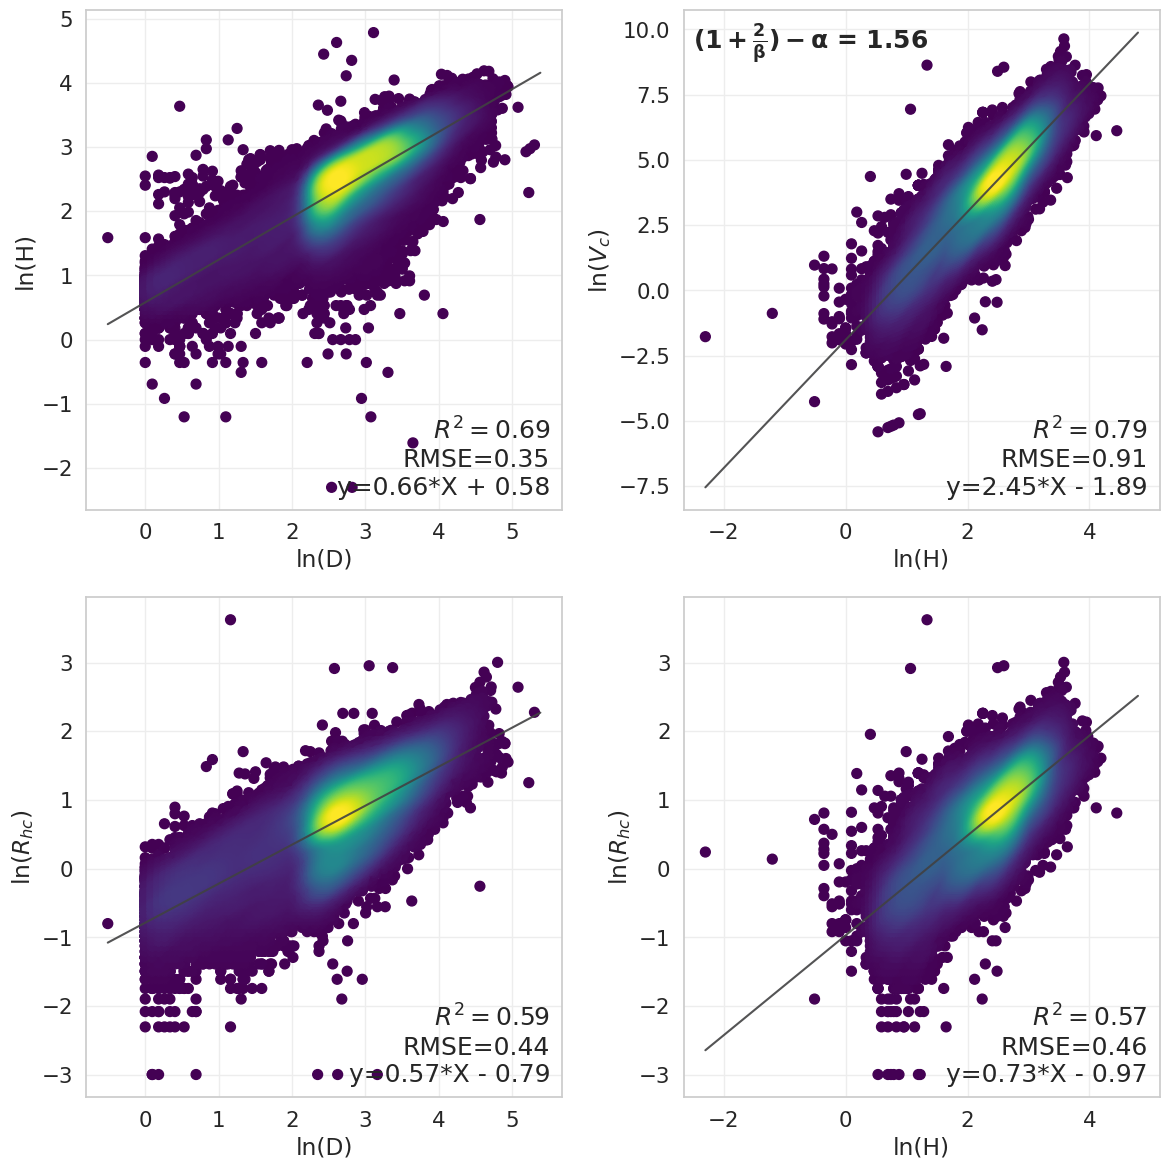

In [15]:
from scipy.stats import gaussian_kde

# ALLOMETRY PLOTTING COMBINING ALL DOMAINS
outdir = "2020to2023"

# Filter for selected domains only used in allometry
selected_domains = ['D01', 'D02', 'D03', 'D04',
                    'D05', 'D06', 'D07', 'D08',
                    'D10', 'D11', 'D12', 'D13', # "D14", # dont include d14
                    'D15', 'D16', 'D17', 'D19', 'D20']
df_filt = neon_vst_filt.loc[neon_vst_filt['domainID'].isin(selected_domains)].copy()

beta_list = []
alpha_list = []
a_list = []
b_list = []
domains = []



fig, axs = plt.subplots(2,2,figsize=(12,12))
ax=axs.flatten()



for var_idx, yvar in enumerate(yvars_list):
    
    # get xvar and labels
    xvar = xvars_list[var_idx]
    xlabel = xlabs_list[var_idx]
    ylabel = ylabs_list[var_idx]


    ## y ~ x
    log_x = np.log(df_filt[xvar].values)
    log_y = np.log(df_filt[yvar].values)
    filter_bool = ~(np.isnan(log_x) | np.isnan(log_y))
    if len(log_x[filter_bool])<=1:
        # not enough samples in filtered dataset
        print("Not enough samples in ", domain)
        # plot_idx+=1
        continue
    # Get regression
    slope, intercept, r_value, p_value, std_err = LinearRegression(log_x,log_y)
    y_pred = slope*log_x+intercept
    
    ## Plot data and regression
    # scatter
    # ax[var_idx].scatter(log_x,log_y,
    #     label=label,
    #     c = colors_list[var_idx],
    #     edgecolors = colors_list[var_idx])
    # Scatter by point density!
    # Calculate the point density
    xy = np.vstack([log_x[filter_bool],log_y[filter_bool]])
    z_gaussian = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last (on top)!
    z_idx = z_gaussian.argsort()
    x, y, z = log_x[filter_bool][z_idx], log_y[filter_bool][z_idx], z_gaussian[z_idx]
    ax[var_idx].scatter(x, y, c=z, s=50, cmap="viridis")

    # reg
    xrange = np.arange(np.nanmin(log_x),np.nanmax(log_x)+.1,.1)
    ax[var_idx].plot(xrange, slope*xrange+intercept, color="#414142", alpha=0.9)
    # subplot aesthetics
    ax[var_idx].set_xlabel(xlabs_list[var_idx])
    ax[var_idx].set_ylabel(ylabs_list[var_idx])
    # Add regression params and eval metrics as text
    rmse = mean_squared_error(y_true=log_y[filter_bool].reshape(-1,1),
                              y_pred=y_pred[filter_bool].reshape(-1,1), squared=False)
    if intercept < 0:
        oper = "-"
    else:
        oper="+"
#     txt = f"y={np.round(slope,2)}*X {oper} {np.absolute(np.round(intercept,2))}\n" \
#     f"RMSE={np.round(rmse,2)}\n"+ "$R^{2}=$" + f"{np.round(r_value**2,2)}" \
#     f"\nn={len(log_y[filter_bool])}"
    
    txt = "$R^{2}=$" + f"{np.round(r_value**2,2)}\n" + f"RMSE={np.round(rmse,2)}\n" \
    f"y={np.round(slope,2)}*X {oper} {np.absolute(np.round(intercept,2))}"
    
    # Add text
    ax[var_idx].text(.975,.02, txt,
                      transform=ax[var_idx].transAxes, ha="right",va="bottom",
                      fontsize=18)
    if var_idx == 0:
        beta = slope
        b = intercept
    elif var_idx==1:
        alpha = slope
        a = intercept
        
# Figure aesthetics
hse = (1+2/beta)-alpha
txt = r"$\mathbf{(1+\frac{2}{\beta})-\alpha}$ = " + f"{np.round(hse,2)}"
# Add text
ax[1].text(.02,.975, txt,
                  transform=ax[1].transAxes, ha="left",va="top",
                  fontsize=18, fontweight="bold")
# Lets save
fig.tight_layout()
# outfp = "../../figs/veg-struct/allom/neon-allsites-allom.png"
outfp = f"../../figs/veg-struct/allom/{outdir}/neon-allsites-allom.png"

fig.savefig(outfp,dpi=300)
        



In [16]:
# Colro dict!
color_dict = {"D01":'#1f77b4',
              "D02": '#aec7e8',
              "D03":'#ff7f0e',
              "D04": '#ffbb78',
              "D05":'#2ca02c',
              "D06": '#98df8a',
              "D07":'#d62728',
              "D08": '#ff9896',
              "D09":'#9467bd',
              "D10": '#c5b0d5',
              "D11":'#8c564b',
              "D12": '#c49c94',
              "D13":'#e377c2',
              "D14": '#f7b6d2',
              "D15":'#7f7f7f',
              "D16": '#c7c7c7',
              "D17":'#bcbd22',
              "D18": '#dbdb8d',
              "D19": '#17becf',
              "D20": '#9edae5'
             }

D01
D02
D03
D04
D05
D06
D07
D08
D10
D11
D12
D13
D15
D16
D17
D19
D20


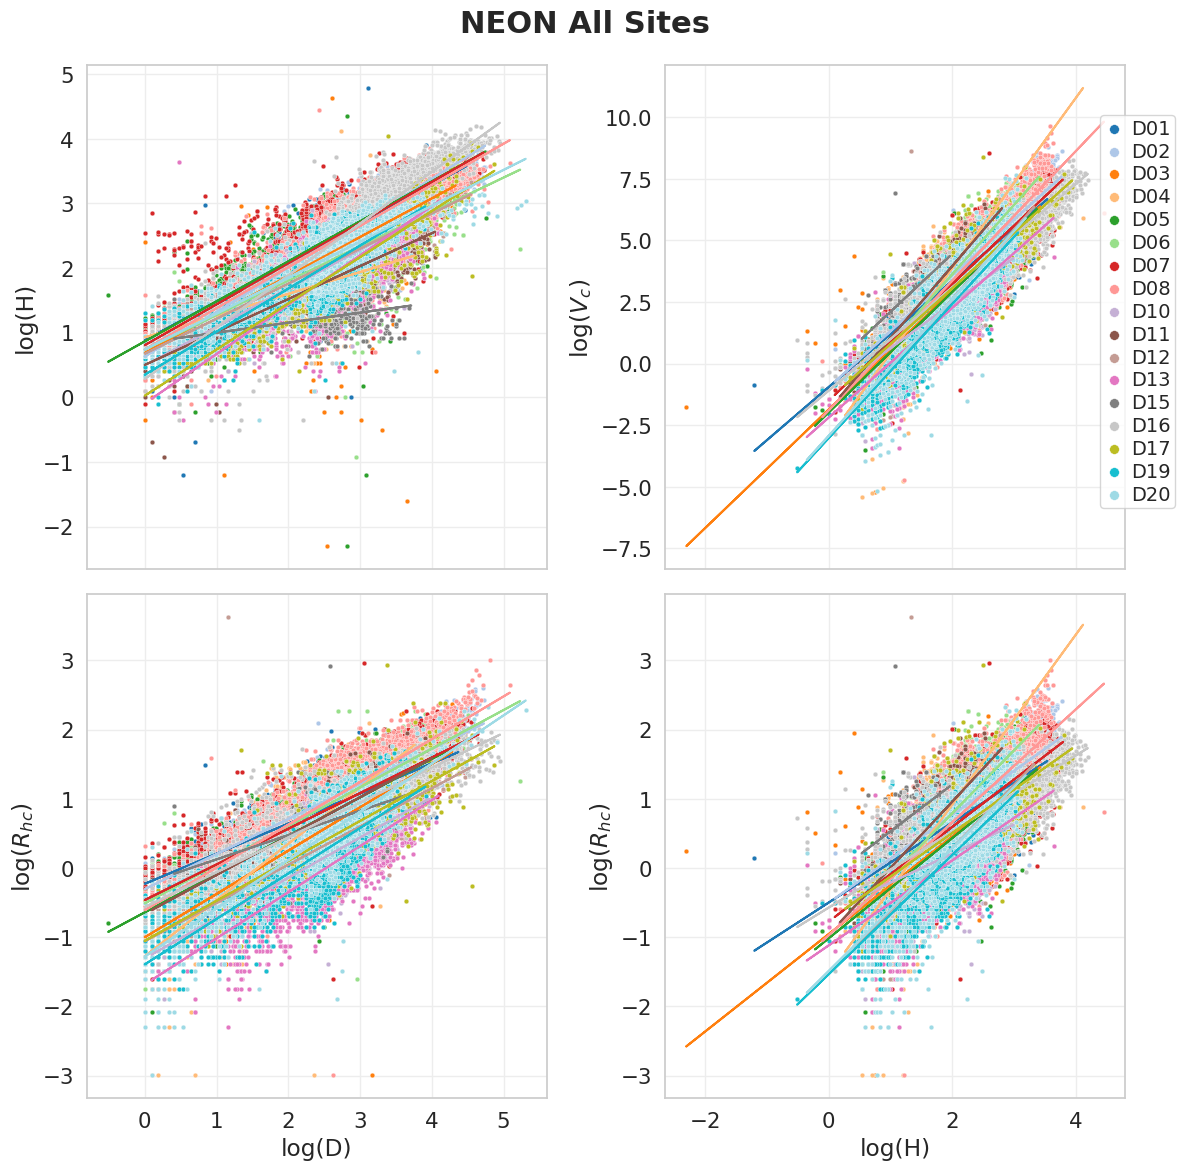

In [19]:

# ALLOMETRY PLOTTING COMBINING ALL DOMAINS
# WITH SEPERATE REGRESSIONS FOR EACH DOMAIN
outdir = "2020to2023"

# Filter for selected domains only used in allometry
selected_domains = ['D01', 'D02', 'D03', 'D04',
                    'D05', 'D06', 'D07', 'D08',
                    'D10', 'D11', 'D12', 'D13',
                    'D15', 'D16', 'D17', 'D19', 'D20']
df_filt = neon_vst_filt.loc[neon_vst_filt['domainID'].isin(selected_domains)].copy()
df_filt = df_filt.sort_values(by="domainID")

beta_list = []
alpha_list = []
a_list = []
b_list = []
domains = []

fig, axs = plt.subplots(2,2,figsize=(12,12),sharex="col")
ax=axs.flatten()
color_idx = 0

for domain, group in df_filt.groupby("domainID"):
    print(domain)
    
    # Generate kwargs for scatterplot! "ec":to_rgba(colors_list[color_idx],1)
    kwargs = {"s":12, "c":color_dict[domain]}

    ## H ~ D
    log_x = np.log(group['stemDiameter'])
    log_y = np.log(group['height'])
    filt_bool = (np.isfinite(log_x) & np.isfinite(log_y))
    log_x = log_x[filt_bool]
    log_y = log_y[filt_bool]
    lr = sm.OLS(log_y, sm.add_constant(log_x,prepend=False)).fit()
    beta = lr.params[0]

    # Add scatterplot
    sns.scatterplot(x=log_x,y=log_y,
                    label=domain,#c=colors_list[color_idx],
                    ax=ax[0],**kwargs)
    # Add regression
    ax[0].plot(log_x, log_x*lr.params[0]+lr.params[1],
               color=color_dict[domain])
    
    h,l = ax[0].get_legend_handles_labels()
    ax[0].get_legend().remove()
    ax[0].set_xlabel("log(D)")
    ax[0].set_ylabel("log(H)")

    ## Crown volume ~ H
    log_x = np.log(group['height'])
    log_y = np.log(group['crown_vol'])
    filt_bool = (np.isfinite(log_x) & np.isfinite(log_y))
    log_x = log_x[filt_bool]
    log_y = log_y[filt_bool]
    lr = sm.OLS(log_y, sm.add_constant(log_x,prepend=False)).fit()
    alpha = lr.params[0]

    # Add scatterplot
    sns.scatterplot(x=log_x,y=log_y,
                    label=domain,c=color_dict[domain],
                    ax=ax[1],s=12,legend=False)
    # Add regression
    ax[1].plot(log_x, log_x*lr.params[0]+lr.params[1],
               color=color_dict[domain])

    ax[1].set_xlabel("log(H)")
    ax[1].set_ylabel(r"log($V_{c}$)")

    ## Hrad ~ D
    log_x = np.log(group['stemDiameter'])
    log_y = np.log(group['avgCrownDiameter']/2)
    filt_bool = (np.isfinite(log_x) & np.isfinite(log_y))
    log_x = log_x[filt_bool]
    log_y = log_y[filt_bool]
    lr = sm.OLS(log_y, sm.add_constant(log_x,prepend=False)).fit()

    # Add scatterplot
    sns.scatterplot(x=log_x,y=log_y,
                    label=domain,c=color_dict[domain],
                    ax=ax[2],s=12,legend=False)
    # Add regression
    ax[2].plot(log_x, log_x*lr.params[0]+lr.params[1],
               color=color_dict[domain])

    ax[2].set_xlabel("log(D)")
    ax[2].set_ylabel("log($R_{hc}$)")

    ## Rhc ~ H
    log_x = np.log(group['height'])
    log_y = np.log(group['avgCrownDiameter']/2)
    filt_bool = (np.isfinite(log_x) & np.isfinite(log_y))
    log_x = log_x[filt_bool]
    log_y = log_y[filt_bool]
    lr = sm.OLS(log_y, sm.add_constant(log_x,prepend=False)).fit()

    # Add scatterplot
    sns.scatterplot(x=log_x,y=log_y,
                    label=domain,c=color_dict[domain],
                    ax=ax[3],s=12,legend=False)
    # Add regression
    ax[3].plot(log_x, log_x*lr.params[0]+lr.params[1],
               color=color_dict[domain])

    ax[3].set_xlabel("log(H)")
    ax[3].set_ylabel("log($R_{hc}$)")
    
    color_idx+=1
    
    # create df to add Scaling Exponents, HSE, regression formula, evalstats
    
    
    
#####################

# add figure aesthetics
fig.suptitle("NEON All Sites",fontweight="bold",fontsize=22)
fig.legend(h,l, loc="upper right", ncols=1,fontsize=14,
           bbox_to_anchor=(1.0,0.9),markerscale=2,
           borderpad=0.2,labelspacing=0.2,
           handlelength=1,handletextpad=0.4,columnspacing=0.5)
fig.tight_layout()
fig.subplots_adjust(right=0.95)
# save to output folder
outfp = f"../../figs/veg-struct/allom/{outdir}/neon-allsites-allom-v2.png"
fig.savefig(outfp,dpi=300)


In [25]:
###########################
###########################
###########################

In [26]:
## Plot allometry between conifer and angio

In [20]:
## Read in NEON taxonomy db, then join to get phylum
neon_tax_db = pd.read_csv("/data/shared/src/arojas/NEON/data/raw/OS_TAXON_PLANT-20220330T142149.csv")

/tmp/ipykernel_3229502/2390284173.py:2: DtypeWarning: Columns (11,13,14,24,26,30,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  neon_tax_db = pd.read_csv("/data/shared/src/arojas/NEON/data/raw/OS_TAXON_PLANT-20220330T142149.csv")


In [21]:
print(neon_tax_db.columns)
print(neon_tax_db.shape)

Index(['taxonTypeCode', 'taxonID', 'acceptedTaxonID', 'scientificName',
       'scientificNameAuthorship', 'taxonRank', 'vernacularName',
       'taxonProtocolCategory', 'nameAccordingToID', 'nameAccordingToTitle',
       'kingdom', 'subkingdom', 'infrakingdom', 'superdivision', 'division',
       'subdivision', 'infradivision', 'parvdivision', 'superphylum', 'phylum',
       'subphylum', 'infraphylum', 'superclass', 'class', 'subclass',
       'infraclass', 'superorder', 'order', 'suborder', 'infraorder',
       'section', 'subsection', 'superfamily', 'family', 'subfamily', 'tribe',
       'subtribe', 'genus', 'subgenus', 'species', 'subspecies', 'variety',
       'subvariety', 'form', 'subform', 'race', 'stirp', 'morph', 'abberation',
       'unspecified', 'speciesGroup', 'specificEpithet',
       'infraspecificEpithet'],
      dtype='object')
(93666, 53)


In [22]:
neon_vst_merged = pd.merge(neon_vst_filt,neon_tax_db[["taxonID","phylum"]], how = 'left',on="taxonID")

In [23]:
print(neon_vst_filt.shape)
print(neon_vst_merged.shape)

(85817, 50)
(85817, 51)


In [24]:
neon_vst_merged['phylum'].unique()

array(['Coniferophyta', 'Magnoliophyta', nan, 'Pteridophyta'],
      dtype=object)

In [25]:
from scipy.stats import gaussian_kde

# ALLOMETRY PLOTTING COMBINING ALL DOMAINS
outdir = "2020to2023"

# Filter for selected domains only used in allometry
selected_domains = ['D01', 'D02', 'D03', 'D04',
                    'D05', 'D06', 'D07', 'D08',
                    'D10', 'D11', 'D12', 'D13', # "D14", # dont include d14
                    'D15', 'D16', 'D17', 'D19', 'D20']
df_filt = neon_vst_merged.loc[neon_vst_merged['domainID'].isin(selected_domains)].copy()

phyla_list = ['Magnoliophyta', 'Coniferophyta']
beta_dict = {'Magnoliophyta':{},"Coniferophyta":{}}
alpha_dict = {'Magnoliophyta':{},"Coniferophyta":{}}

fig, axs = plt.subplots(2,2,figsize=(12,12))
ax=axs.flatten()



for var_idx, yvar in enumerate(yvars_list):
    
    # get xvar and labels
    xvar = xvars_list[var_idx]
    xlabel = xlabs_list[var_idx]
    ylabel = ylabs_list[var_idx]
    
    for phylum in phyla_list:

        vst_phylum = df_filt.loc[df_filt['phylum']==phylum].copy()

        ## y ~ x
        log_x = np.log(vst_phylum[xvar].values)
        log_y = np.log(vst_phylum[yvar].values)
        filter_bool = ~(np.isnan(log_x) | np.isnan(log_y))
        if len(log_x[filter_bool])<=1:
            # not enough samples in filtered dataset
            print("Not enough samples in ", domain)
            # plot_idx+=1
            continue
        # Get regression
        slope, intercept, r_value, p_value, std_err = LinearRegression(log_x,log_y)
        y_pred = slope*log_x+intercept

        ## Plot data and regression
        # scatter
        # ax[var_idx].scatter(log_x,log_y,
        #     label=label,
        #     c = colors_list[var_idx],
        #     edgecolors = colors_list[var_idx])
        
        # Scatter by point density!
        # Calculate the point density
        xy = np.vstack([log_x[filter_bool],log_y[filter_bool]])
        z_gaussian = gaussian_kde(xy)(xy)
        # Sort the points by density, so that the densest points are plotted last (on top)!
        z_idx = z_gaussian.argsort()
        x, y, z = log_x[filter_bool][z_idx], log_y[filter_bool][z_idx], z_gaussian[z_idx]
        if phylum == "Magnoliophyta":
            cmap="autumn"
        else:
            cmap="winter"
        ax[var_idx].scatter(x, y, c=z, s=30,
                            cmap=cmap,label=phylum)

        # reg plotting
        xrange = np.arange(np.nanmin(log_x),np.nanmax(log_x)+.1,.1)
        ax[var_idx].plot(xrange, slope*xrange+intercept, color="#414142", alpha=0.9)
        # subplot aesthetics
        ax[var_idx].set_xlabel(xlabs_list[var_idx])
        ax[var_idx].set_ylabel(ylabs_list[var_idx])
        # Add regression params and eval metrics as text
        rmse = mean_squared_error(y_true=log_y[filter_bool].reshape(-1,1),
                                  y_pred=y_pred[filter_bool].reshape(-1,1), squared=False)
        if intercept < 0:
            oper = "-"
        else:
            oper="+"
        
        if phylum == "Magnoliophyta":
            txt = f"y={np.round(slope,2)}*X {oper} {np.absolute(np.round(intercept,2))}\n" \
            f"RMSE={np.round(rmse,2)}\n" + "$R^{2}=$" + f"{np.round(r_value**2,2)}"
            ax[var_idx].text(.02,.98, txt,color="#8a0707",
                  transform=ax[var_idx].transAxes, ha="left",va="top",
                  fontsize=18,fontweight="semibold")
        else:
            txt = "$R^{2}=$" + f"{np.round(r_value**2,2)}\n" + f"RMSE={np.round(rmse,2)}\n" \
            f"y={np.round(slope,2)}*X {oper} {np.absolute(np.round(intercept,2))}"
            ax[var_idx].text(.98,.02, txt,color="#0b1c7d",
                  transform=ax[var_idx].transAxes, ha="right",va="bottom",
                  fontsize=18,fontweight="semibold")
            
        if var_idx == 0:
            beta_dict[phylum]['slope'] = slope
            beta_dict[phylum]['intercept'] = intercept
        elif var_idx==1:
            alpha_dict[phylum]['slope'] = slope
            alpha_dict[phylum]['intercept'] = intercept

# Figure aesthetics
beta = beta_dict[phyla_list[0]]['slope']
alpha = alpha_dict[phyla_list[0]]['slope']
hse_angio = (1+2/beta)-alpha
beta = beta_dict[phyla_list[1]]['slope']
alpha = alpha_dict[phyla_list[1]]['slope']
hse_conifer = (1+2/beta)-alpha
txt_conifer = f"HSE={np.round(hse_conifer,2)}"
txt_angio = f"HSE={np.round(hse_angio,2)}"
# Add text
ax[1].text(.02,.8, txt_angio,
           color="#8a0707",
           transform=ax[1].transAxes, ha="left",va="top",
           fontsize=18, fontweight="semibold")
ax[1].text(.98,.2, txt_conifer,
           color="#0b1c7d",
           transform=ax[1].transAxes, ha="right",va="bottom",
           fontsize=18, fontweight="semibold")
# Legend
h,l = ax[0].get_legend_handles_labels()
fig.legend(h,l,loc="upper center",bbox_to_anchor=(0.5,1.005),ncols=2,
          labelspacing=0.4,handletextpad=0.1,columnspacing=0.2,
           fontsize=16)
# Lets save
fig.tight_layout()
fig.subplots_adjust(top=0.96)
fig.savefig(f"../../figs/veg-struct/allom/{outdir}/neon-allsites-allom-phylum.png",dpi=300)
plt.close()




In [26]:
#####################

In [31]:
###################
## Get coefficient and intercept from log-log models for each var per domain, then plot coef. vs intercept
###################

In [32]:
# from sklearn.linear_model import LinearRegression
# def get_slope_intercept(x,y):
    
#     # Add regression params
#     # vstack xy for easier boolean
#     xy = np.vstack([x,y]).T
#     filterBoolx = np.isfinite(xy[:,0])
#     xy = xy[filterBoolx]
#     filterBooly = np.isfinite(xy[:,1])    
#     xy = xy[filterBooly]
    
#     ## Linear regression
#     # Get predicted y
#     lr_model = LinearRegression(fit_intercept=True).fit(xy[:,0].reshape(-1,1), xy[:,1])
#     slope, rsquared = lr_model.coef_[0], lr_model.score(xy[:,0].reshape(-1, 1),
#                                                   xy[:,1])
#     y_pred = slope*xy[:, 0] + lr_model.intercept_
#     slope_ols = slope # to return original intercept
    
#     return slope_ols, lr_model.intercept_

In [27]:
## Loop through domains
h_dict = {"slope":[],"intercept":[]}
rhc_dict = {"slope":[],"intercept":[]}
rvc_dict = {"slope":[],"intercept":[]}
vc_dict = {"slope":[],"intercept":[]}
rhc_h_dict = {"slope":[],"intercept":[]}
domain_list = []


for domain, group in neon_vst_filt.groupby("domainID"):
    print(domain)
    
    ## Rhc ~ D
    log_x = np.log(group['stemDiameter'])
    log_y = np.log(group["avgCrownDiameter"]/2)
    if np.all(np.isnan(log_x)) or np.all(np.isnan(log_y)):
        print(f"Not enough data in domain: {domain}")
        continue
    try:
        slope, intercept, r_value, p_value, std_err = LinearRegression(log_x,log_y)
    except:
        print("error getting slope")
        continue
    rhc_dict['slope'].append(slope)
    rhc_dict['intercept'].append(intercept)
    
    ## H ~ D
    log_x = np.log(group['stemDiameter'])
    log_y = np.log(group['height'])
    slope, intercept, r_value, p_value, std_err = LinearRegression(log_x,log_y)
    h_dict['slope'].append(slope)
    h_dict['intercept'].append(intercept)
    
#     ## Rvc ~ H
#     log_x = np.log(group['height'])
#     log_y = np.log(group["ninetyCrownDiameter"]/2)
#     b1, b0 = get_slope_intercept(log_x,log_y)
#     rvc_dict['slope'].append(b1)
#     rvc_dict['intercept'].append(b0) for the biggest loop tin here
    
    ## Vc ~ H
    log_x = np.log(group['height'])
    log_y = np.log(group["crown_vol"])
    slope, intercept, r_value, p_value, std_err = LinearRegression(log_x,log_y)
    vc_dict['slope'].append(slope)
    vc_dict['intercept'].append(intercept)
    
    ## Rhc ~ H
    log_x = np.log(group['height'])
    log_y = np.log(group["avgCrownDiameter"]/2)
    slope, intercept, r_value, p_value, std_err = LinearRegression(log_x,log_y)
    rhc_h_dict['slope'].append(slope)
    rhc_h_dict['intercept'].append(intercept)
    
    # add domain to list
    domain_list.append(domain)

    

D01
D02
D03
D04
D05
D06
D07
D08
D10
D11
D12
D13
D14
Not enough data in domain: D14
D15
D16
D17
D19
D20


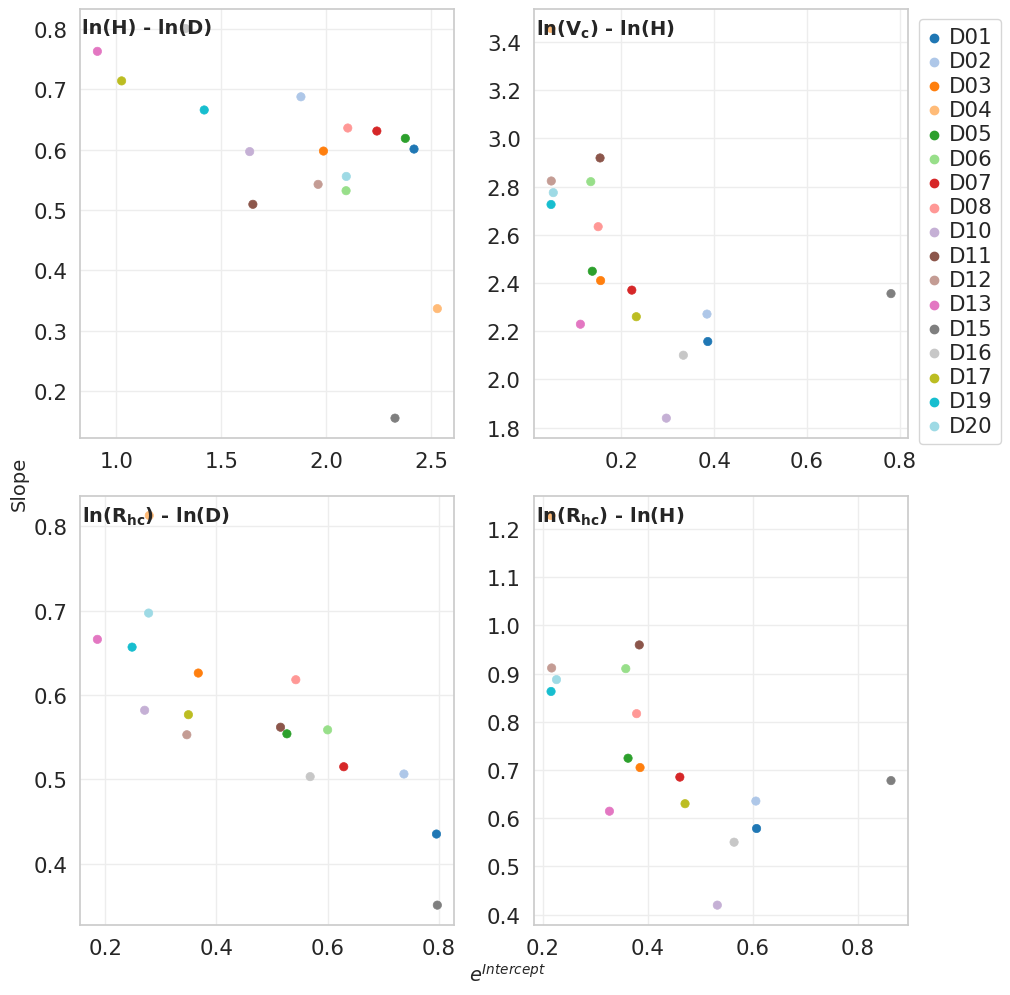

In [34]:
#########
# Seaborn aesthetics
sns.set_context("notebook")
sns.set_theme(style="whitegrid", font_scale=1.4,
              rc={'grid.color': '#ededed'})
# output directory
outdir = "2020to2023"

# Plot coef vs intercept for each allom (4x4)
fig,axs = plt.subplots(2,2,figsize=(10,10))
ax = axs.flatten()
kwargs = {"ec":to_rgba("#141414", alpha=.95),"linewidth":0.4} # to_rgba("#141414", alpha=.95)

# H ~ D
# ax[0].scatter(h_dict['intercept'],h_dict['slope'],c=domain_list, **kwargs)
sns.scatterplot(x=np.exp(h_dict['intercept']),y=h_dict['slope'],
                hue=domain_list,palette = color_dict,ax=ax[0], ec="face")
# subplot aesthetics
ax[0].text(0.005,.98,"ln(H) - ln(D)",
           ha="left",va="top",fontsize=14,fontweight="bold",
           transform=ax[0].transAxes)
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
# get legend items
handles, labels = ax[0].get_legend_handles_labels()
ax[0].get_legend().remove()

# Vc ~ H
sns.scatterplot(x=np.exp(vc_dict['intercept']),y=vc_dict['slope'],
                hue=domain_list,palette = color_dict,ax=ax[1], ec="face", legend=False)
ax[1].text(0.005,.98,r"ln($\mathbf{V_{c}}$) - ln(H)",
           ha="left",va="top",fontsize=14,fontweight="bold",
           transform=ax[1].transAxes)
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)

# Rhc ~ D
sns.scatterplot(x=np.exp(rhc_dict['intercept']),y=rhc_dict['slope'],
                hue=domain_list,palette = color_dict,ax=ax[2], ec="face", legend=False)
ax[2].text(0.005,.98,r"ln($\mathbf{R_{hc}}$) - ln(D)",
           ha="left",va="top",fontsize=14,fontweight="bold",
           transform=ax[2].transAxes)
ax[2].set_xlabel(None)
ax[2].set_ylabel(None)

# Rhc ~ H
sns.scatterplot(x=np.exp(rhc_h_dict['intercept']),y=rhc_h_dict['slope'],
                hue=domain_list,palette = color_dict,ax=ax[3], ec="face", legend=False)
ax[3].text(0.005,.98,r"ln($\mathbf{R_{hc}}$) - ln(H)",
           ha="left",va="top",fontsize=14,fontweight="bold",
           transform=ax[3].transAxes)
ax[3].set_xlabel(None)
ax[3].set_ylabel(None)

# Figure aesthetics
fig.legend(handles, labels,
           loc = 'upper left',bbox_to_anchor=(0.9,0.975),
           ncol=1, labelspacing=0.2, 
           handletextpad=0.4,columnspacing=0.8,handlelength=0.6)
fig.text(0.5, 0.002, '$e^{Intercept}$', ha='center',fontsize=14)
fig.text(0.002, 0.5, 'Slope', va='center', rotation='vertical',fontsize=14)
fig.tight_layout()
fig.subplots_adjust(right=0.9)
fig.savefig(f"../../figs/veg-struct/allom/{outdir}/DOMAINS-allom-slope-intercept-scatter.png",dpi=300)

In [29]:
##############
##############
##############

In [35]:
# Read in allom data and plot HSE ~ beta
allom_df = pd.read_csv("../../data/output/NEON-DOMAINS-HSE-2020to2023.csv")

In [36]:
allom_df.columns

Index(['domain', 'alpha', 'beta', 'a', 'b', 'alpha_R2', 'alpha_rmse',
       'beta_R2', 'beta_rmse', 'HSE', 'k'],
      dtype='object')

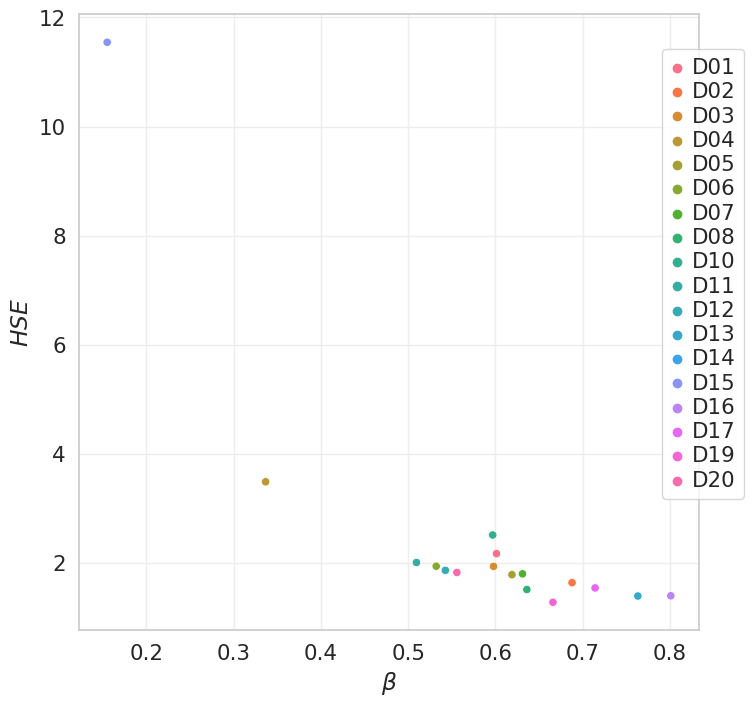

In [37]:
# Seaborn aesthetics
sns.set_context("notebook")
sns.set_theme(style="whitegrid", font_scale=1.4,
              rc={'grid.color': '#ededed'})
outdir="2020to2023"

# Plot coef vs intercept for each allom (4x4)
fig,ax = plt.subplots(1,1,figsize=(8,8))

sns.scatterplot(x=allom_df['beta'].values, y=allom_df['HSE'].values,
                hue=allom_df['domain'].values,ax=ax)
# get legend items
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
# subplot aesthetics
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$HSE$")

# Figure aesthetics
fig.legend(handles, labels,
           loc = 'upper right',bbox_to_anchor=(0.97,0.85),
           ncol=1, labelspacing=0.2, 
           handletextpad=0.4,columnspacing=0.8,handlelength=0.6)
fig.savefig(f"../../figs/veg-struct/allom/{outdir}/DOMAINS-HSE-beta-scatterplot.png",dpi=300)
